
# Week 3 Live Demo — PCA and K-Means on Iris

UCL AI Society - November 2025

## 0. Imports and Utilities

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler


## 1. Load Iris

The Iris dataset has **150 samples** and **4 features** (sepal length/width, petal length/width) across **3 species**.


In [ ]:
iris = load_iris()
iris.feature_names

df=pd.DataFrame(iris.data, columns=iris.feature_names)

print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [ ]:
# load our features
X = iris.data.astype(float)

# rescale X -> so our mean is 0 and our std is 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# load our labels (for plotting)
y = iris.target

print("Data shape:", X.shape)
print("Feature means (after scaling):", X.mean(axis=0).round(4))
print("Feature stds  (after scaling):", X.std(axis=0).round(4))

Data shape: (150, 4)
Feature means (after scaling): [-0. -0. -0. -0.]
Feature stds  (after scaling): [1. 1. 1. 1.]



## 2. PCA

**Idea**  
PCA finds **orthonormal directions** (principal components) that maximize variance.

**Steps**
1. Center the data (already done by standardization).
2. Compute the empirical covariance $S = \frac{1}{N} X^\top X$.
3. Compute eigenvalues/eigenvectors of $S$.
4. Sort eigenpairs by descending eigenvalue.
5. Project onto top $k$ components.

Eigenvalues (descending): [2.9185 0.914  0.1468 0.0207]
Explained variance ratio: [0.7296 0.2285 0.0367 0.0052]


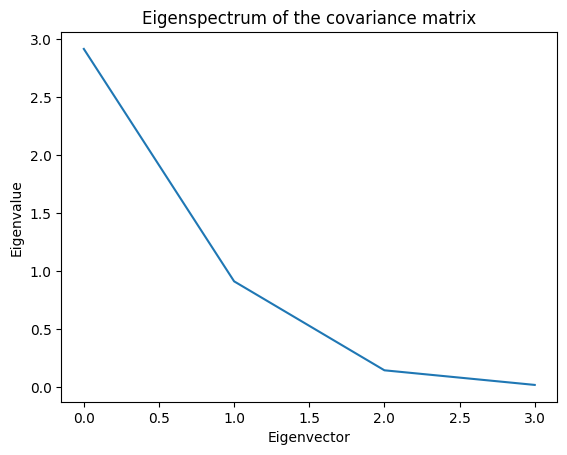

In [ ]:
def get_covariance_eigenspectrum(X):
  N = X.shape[0]
  S = (X.T @ X) / N                   # covariance matrix (since X is standardized)
  evals, evecs = np.linalg.eigh(S)    # symmetric -> eigh
  order = np.argsort(evals)[::-1]
  evals, evecs = evals[order], evecs[:, order]
  return evals, evecs

evals, evecs = get_covariance_eigenspectrum(X)

print("Eigenvalues (descending):", np.round(evals, 4))
print("Explained variance ratio:", np.round(evals/np.sum(evals), 4))

# Let's plot the eigenspectrum.
# Notice the shape: the first two eigenvectors capture almost all the variance!
plt.plot(evals)
plt.xlabel("Eigenvector")
plt.ylabel("Eigenvalue")
plt.title("Eigenspectrum of the covariance matrix")
plt.show()

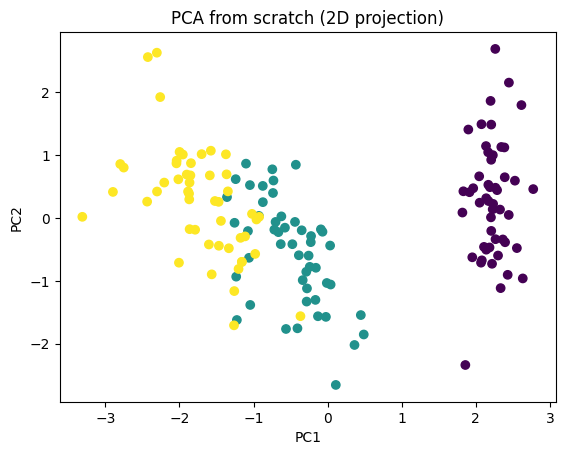

In [ ]:
def pca(X, k):
  _, evecs = get_covariance_eigenspectrum(X)
  U = evecs[:, :k]
  Z = X @ U
  return Z

Z = pca(X, k=2)

# Visualize 2D projection. We've lost interpretability: we don't know what those
# axis correspond to. Can we still take a guess? Hint: look at our features.
plt.scatter(Z[:,0], Z[:,1], c=y if y is not None else "tab:blue", cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA from scratch (2D projection)")
plt.show()


### 2.1 PCA with scikit-learn



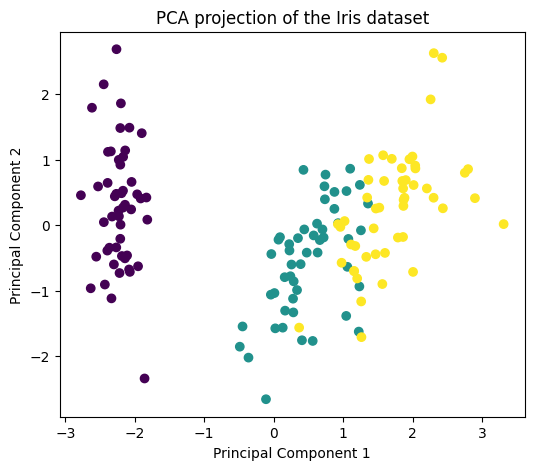

In [ ]:
from sklearn.decomposition import PCA

# Run PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA projection of the Iris dataset')
plt.show()


## 3. K-Means from Scratch

In [ ]:
def plot_kmeans(Z, centers, labels, it):
  plt.scatter(Z[:,0], Z[:,1], c=labels, cmap='viridis')
  plt.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=100, label='centers')
  plt.legend()
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title(f"K-Means from scratch on PCA(2) - Step 3 - Iter {it+1}")
  plt.show()

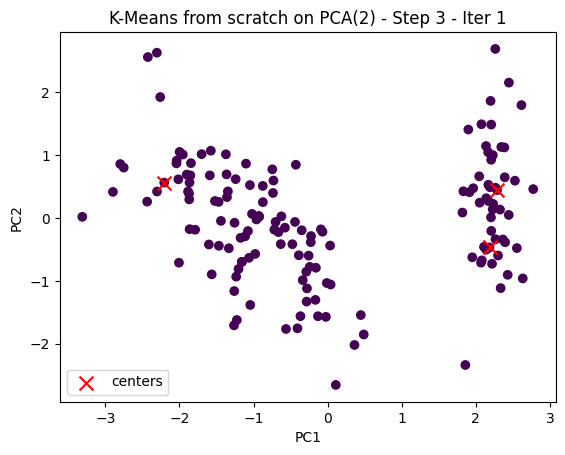

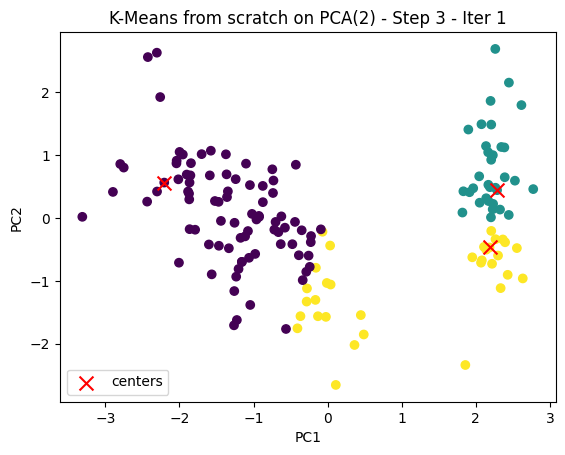

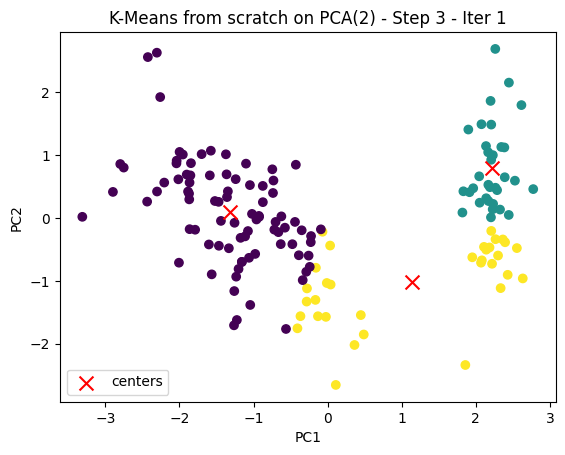

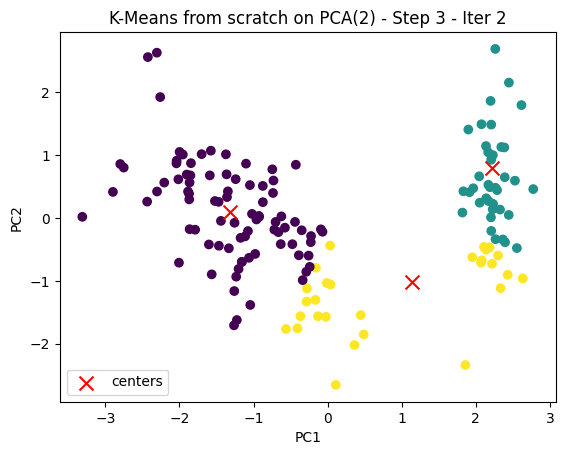

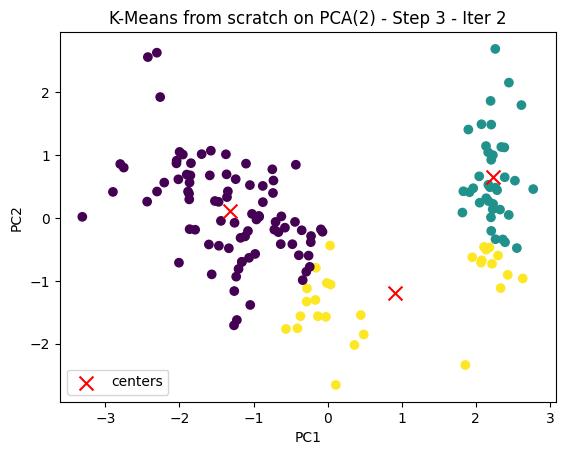

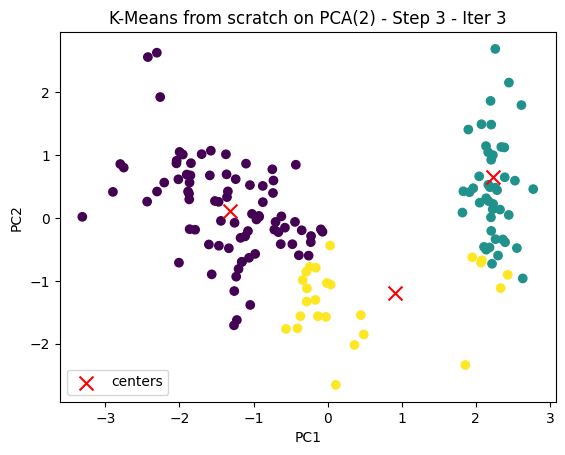

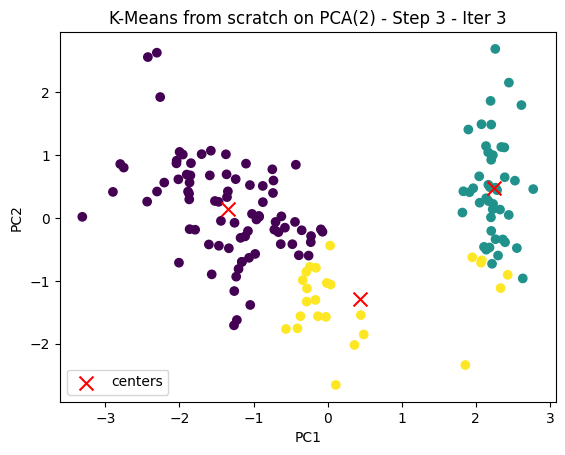

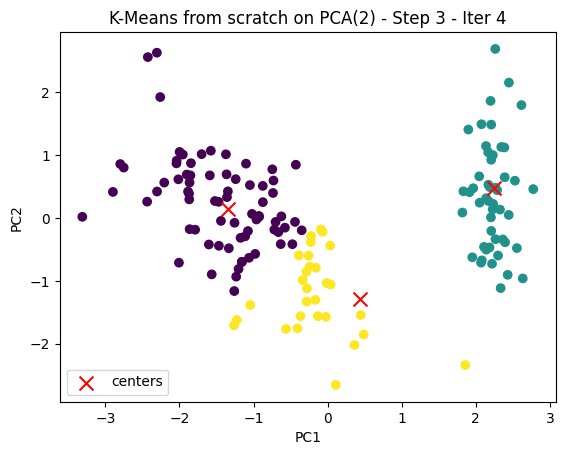

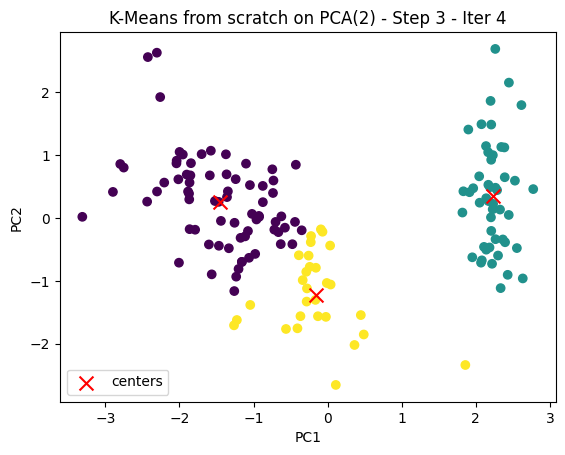

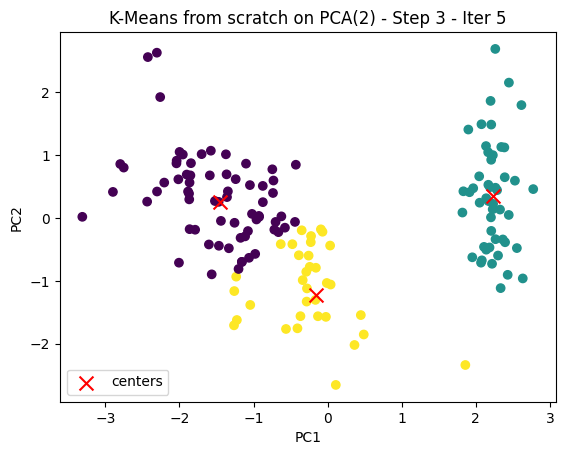

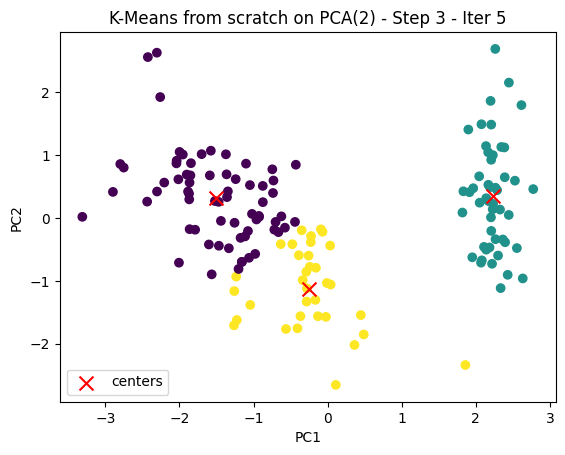

In [ ]:
def kmeans_from_scratch(X, K, max_iters=5):
  rng = np.random.default_rng()
  N = X.shape[0]

  # Step 1: Init, choose K random distinct points
  centers = X[rng.choice(N, size=K, replace=False)].copy()
  labels = np.zeros(N, dtype=int)

  plot_kmeans(Z, centers, labels, 0)
  it = 0
  for it in range(max_iters):

    # Step 2: Assign points to their closest clusters
    labels= list()
    for x in X:
      labels.append(np.argmin(np.linalg.norm(centers - x, axis=1)))
    labels = np.array(labels)
    plot_kmeans(Z, centers, labels, it)

    # Step 3: Update the cluster centers as the mean of the points in that cluster

    centers = list()
    for k in range(K):
      centers.append(np.mean(X[labels == k], axis=0))
    centers = np.array(centers)

    plot_kmeans(Z, centers, labels, it)


# We'll cluster in the 2D PCA space for visualization.
# Notice that we almost fully converge after the first iteration!
# Also note the convergence isn't that good... Should have used EM!
# What happens if we change the value of K? Let's try!
kmeans_from_scratch(Z, K=3)

### 3.1 Confirm K-Means with scikit-learn

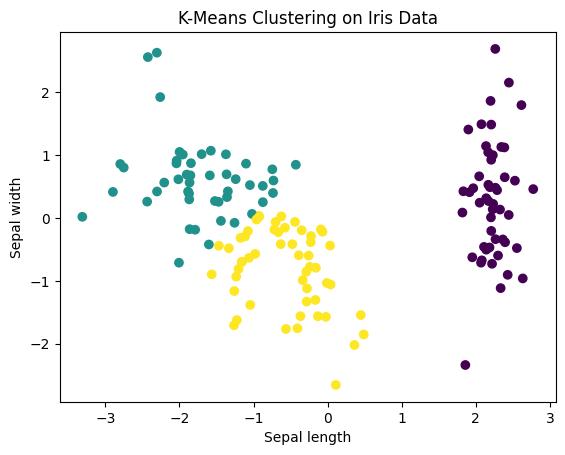

In [ ]:
from sklearn.cluster import KMeans

# Run K-Means
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(Z)

# Visualize first two features
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('K-Means Clustering on Iris Data')
plt.show()